# 4. Second Hybrid method with Le + AQC Unitary

Ising model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ropt_aqc.initialise_hamiltonians import get_hamiltonian_terms

method = 'hybrid-unitary'
num_sites = 6
degree = 2
n_repetitions = 6
n_id_layers = 0

In [3]:
# Ising-1d
J=1.
t = 0.25
g=0.75
h=0.6
system = 'ising-1d'

terms, params = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=J, g=g, h=h)

J = params['J']
h = params['h']
g = params['g']

In [4]:
from ropt_aqc.spin_systems import get_brickwall_trotter_gates_spin_chain
import numpy as np

gates_ising = get_brickwall_trotter_gates_spin_chain(t=t, n_sites=num_sites, n_repetitions=n_repetitions, hamiltonian=system, degree=degree, J=J, g=g, h=h)
print(np.array(gates_ising).shape)  # Should be (N, 4, 4) for 2-qubit gates

(33, 4, 4)


In [5]:
# Matrices for qc
from ropt_aqc.brickwall_circuit import get_initial_gates

gates_initial = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=False, J=-J, g=g, h=h)
print(np.array(gates_initial).shape) 

/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


(33, 4, 4)


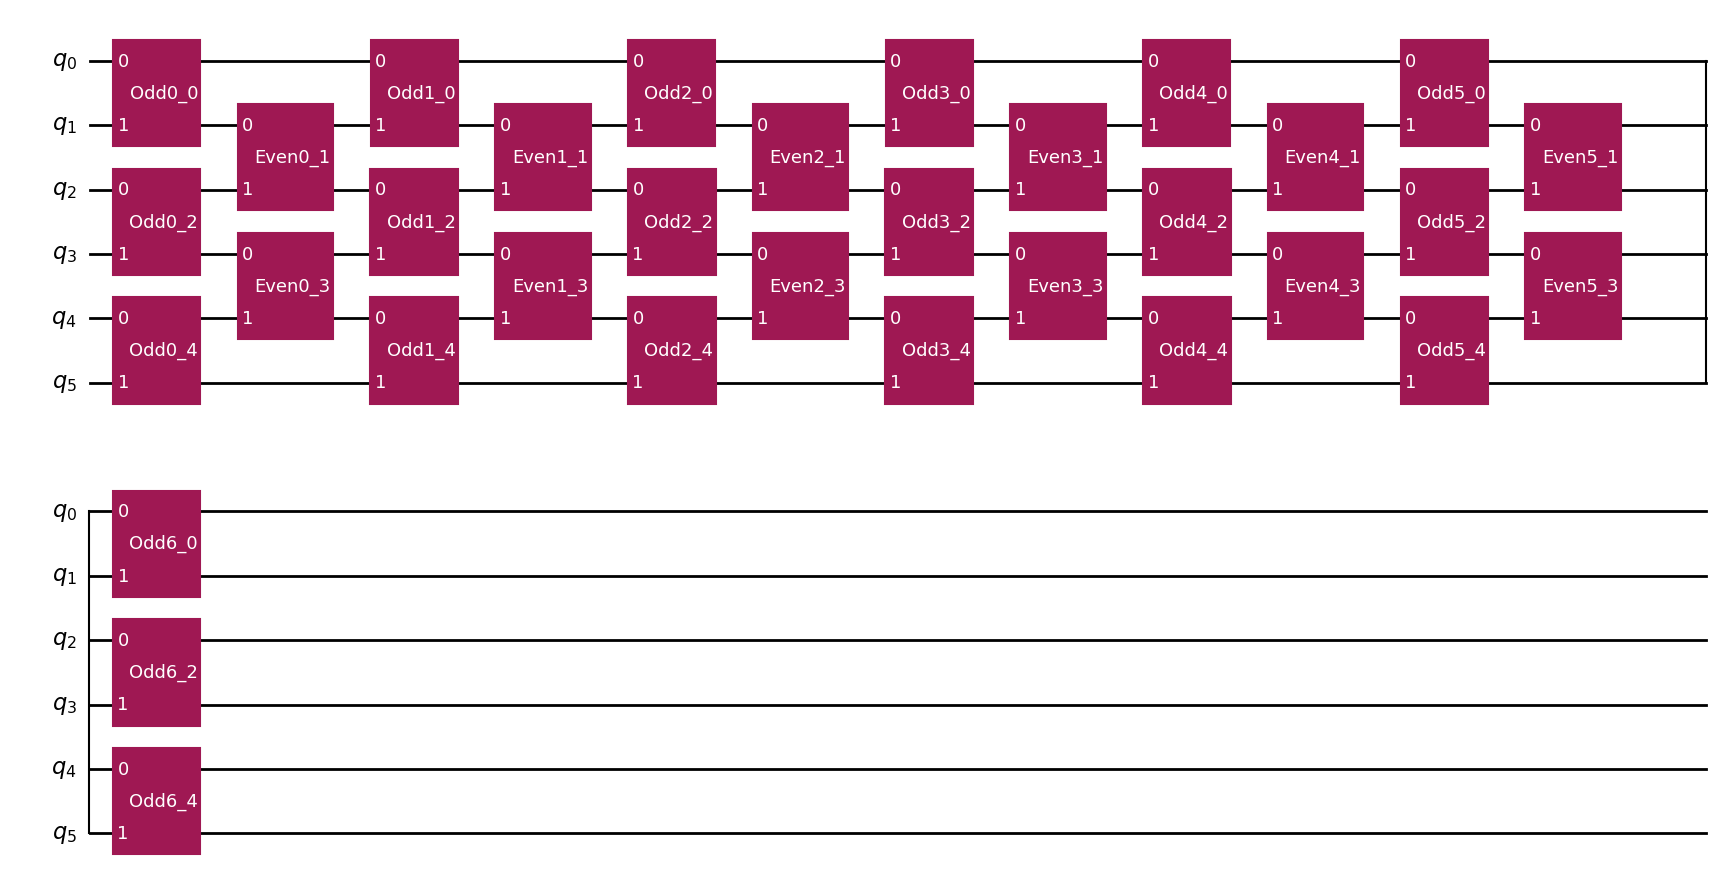

In [6]:
from ropt_aqc.circuit_building import transform_to_bw_qc_unitarygate

qc_initial = transform_to_bw_qc_unitarygate(num_sites=num_sites, n_repetitions=n_repetitions, system = system, gates=gates_initial)
depth_initial = qc_initial.depth()
qc_initial.draw('mpl')

In [7]:
# TN for optimisation
from ropt_aqc.brickwall_circuit import get_initial_gates
gates = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=True, J=J, g=g, h=h)
print(np.array(gates).shape)  # Should be (N, 4, 4) for 2-qubit gates


(33, 2, 2, 2, 2)


In [8]:
from ropt_aqc.save_model import load_reference
import os
import yaml
repo_root = "/Users/aag/Documents/ropt-aqc/"
config_file = os.path.join(repo_root, "run", system, "configs", "config.yml") 

with open(config_file, "r") as f:
    config = yaml.safe_load(f)

config['reference_dir'] = f'/Users/aag/Documents/ropt-aqc/run/{system}/reference'

U_ref, t, _, _, _, _, _, _, _, J, g, h= load_reference(config['reference_dir'], config['n_sites'], config['n_repetitions'], config['t'])

In [9]:
from ropt_aqc.tn_helpers import left_to_right_QR_sweep

U_ref = left_to_right_QR_sweep(U_ref, get_norm=False, normalize=config['normalize_reference'])
print("U_ref shape:", [m.shape for m in U_ref])

U_ref shape: [(1, 2, 2, 4), (4, 2, 2, 16), (16, 2, 2, 64), (64, 2, 2, 16), (16, 2, 2, 4), (4, 2, 2, 1)]


Start Riemannian ADAM optimization ...
	 0 	Current cost:  3.331719922172738e-08
	 1 	Current cost:  0.0002420817935351316
	 2 	Current cost:  2.819176962365333e-05
	 3 	Current cost:  7.134548373954885e-05
	 4 	Current cost:  9.923806588196804e-05
	 5 	Current cost:  7.463168824273225e-05
	 6 	Current cost:  5.739986791897245e-05
	 7 	Current cost:  4.369692086991783e-05
	 8 	Current cost:  2.408442793155885e-05
	 9 	Current cost:  1.7491859328089276e-05
	 10 	Current cost:  3.3049526472428425e-05
	 11 	Current cost:  4.73608833706507e-05
	 12 	Current cost:  3.7766600127442373e-05
	 13 	Current cost:  1.4842315301688558e-05
	 14 	Current cost:  4.075123828162219e-06
	 15 	Current cost:  1.2682135666297611e-05
	 16 	Current cost:  2.3814766137553178e-05
	 17 	Current cost:  2.2371357297767958e-05
	 18 	Current cost:  1.2831460248330373e-05
	 19 	Current cost:  7.523087038219245e-06
	 20 	Current cost:  9.178360141026687e-06
	 21 	Current cost:  1.0950216797089851e-05
	 22 	Current cos

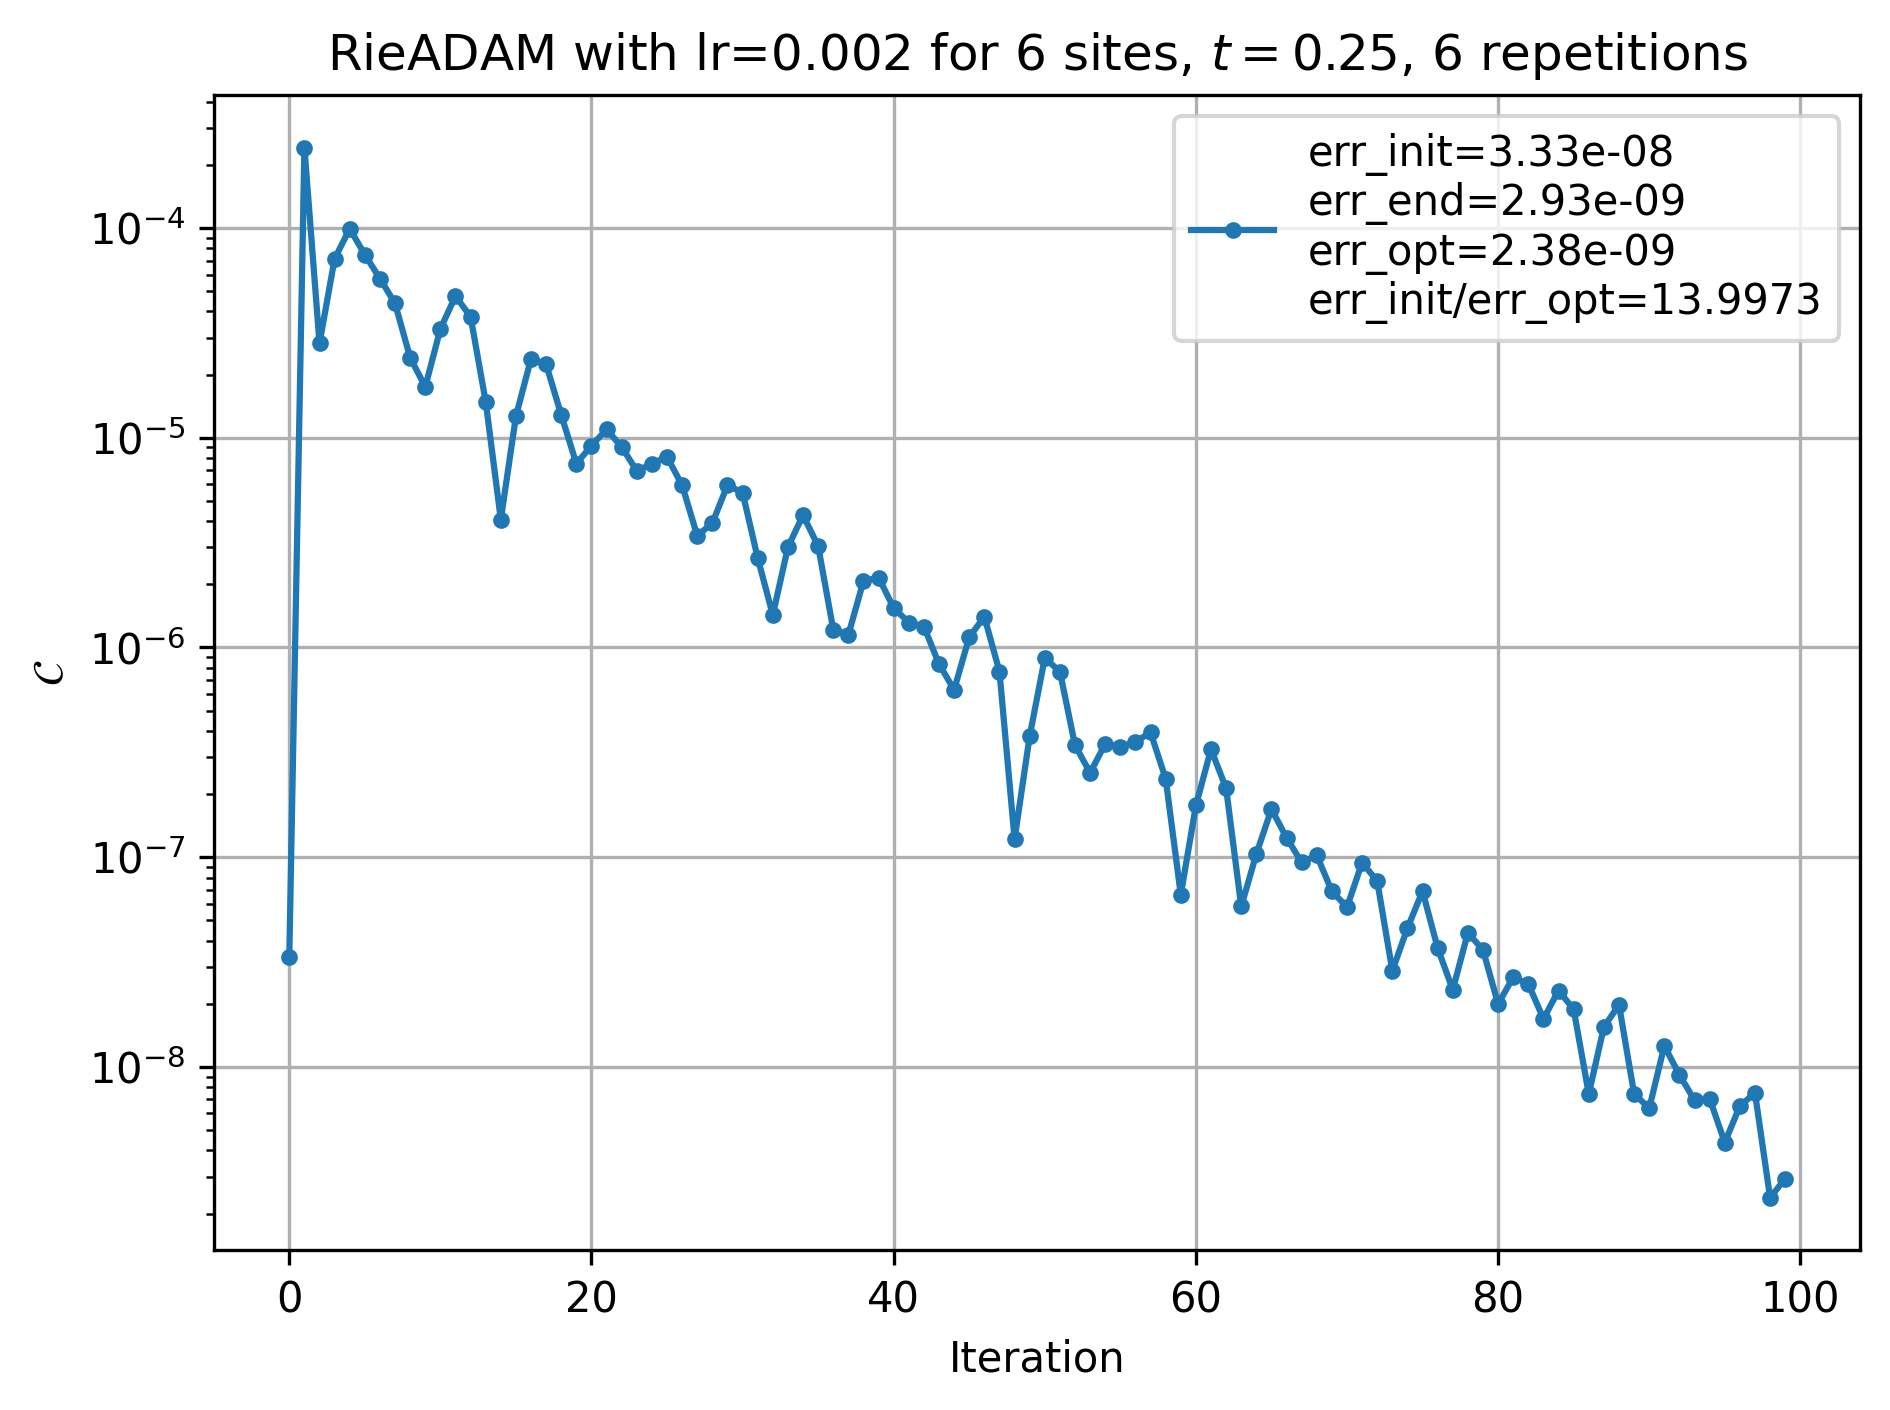

In [10]:
from ropt_aqc.brickwall_opt import optimize_swap_network_circuit_RieADAM

gates_optimised, err_iter = optimize_swap_network_circuit_RieADAM(config, U_ref, gates)

In [11]:
# from qiskit import QuantumCircuit
# from qiskit.quantum_info import Statevector
# from ropt_aqc.comparison_methods import compress_HS

# N_vals = range(1,depth_initial)

# df, gates_optimised_reshaped = compress_HS(gates, config, U_ref, N_vals, qc_initial)

In [12]:
# from ropt_aqc.brickwall_opt import plot_fidelity

# elbow_N, plateau_N = plot_fidelity(df, 'statevector_fidelity', n_repetitions, 1e-3, method, system)

In [13]:
# # Compress circuit
# N_vals = [int(elbow_N)]
# df_compressed, gates_optimised_reshaped_compressed = compress_HS(gates, config, U_ref, N_vals, qc_initial)

(33, 4, 4)
13


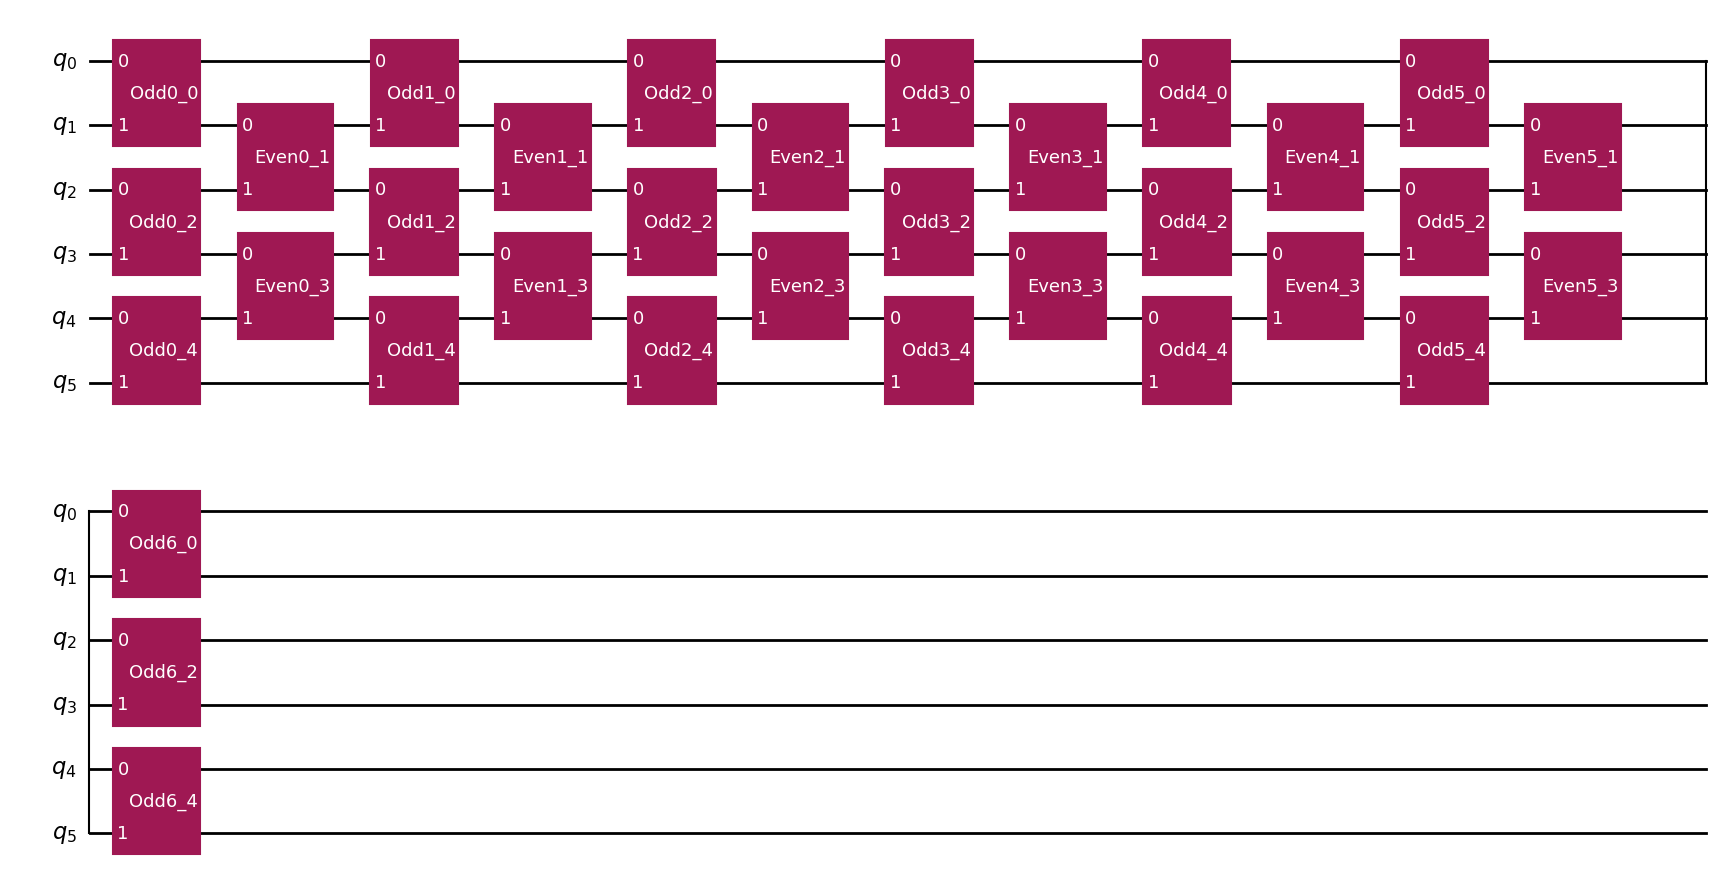

In [14]:
gates_optimised = gates_optimised.reshape((len(gates_optimised), 4, 4))
print(gates_optimised.shape)

qc_opt = transform_to_bw_qc_unitarygate(num_sites=num_sites, n_repetitions=n_repetitions, system = system, gates=gates_optimised)
depth_opt = qc_opt.depth()
print(depth_opt)
qc_opt.draw('mpl')

In [15]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_pauli_op
from qiskit.quantum_info import SparsePauliOp
from rustworkx.generators import path_graph

hamiltonian = hamiltonian_to_sparse_pauli_op(terms, num_qubits=num_sites)
print('Hamiltonian: ', hamiltonian)

observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (num_sites // 2 - 1, num_sites // 2), 1.0)], num_qubits=num_sites
)
print("Observable:", observable)

coupling_map = path_graph(num_sites)

Hamiltonian:  SparsePauliOp(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ', 'ZIIIII', 'XIIIII', 'IZIIII', 'IXIIII', 'IIZIII', 'IIXIII', 'IIIZII', 'IIIXII', 'IIIIZI', 'IIIIXI', 'IIIIIZ', 'IIIIIX'],
              coeffs=[1.        +0.j, 1.        +0.j, 1.        +0.j, 1.        +0.j,
 1.        +0.j, 0.60000002+0.j, 0.75      +0.j, 0.60000002+0.j,
 0.75      +0.j, 0.60000002+0.j, 0.75      +0.j, 0.60000002+0.j,
 0.75      +0.j, 0.60000002+0.j, 0.75      +0.j, 0.60000002+0.j,
 0.75      +0.j])
Observable: SparsePauliOp(['IIZZII'],
              coeffs=[1.+0.j])


This single Trotter step circuit will be repeated 256 times:


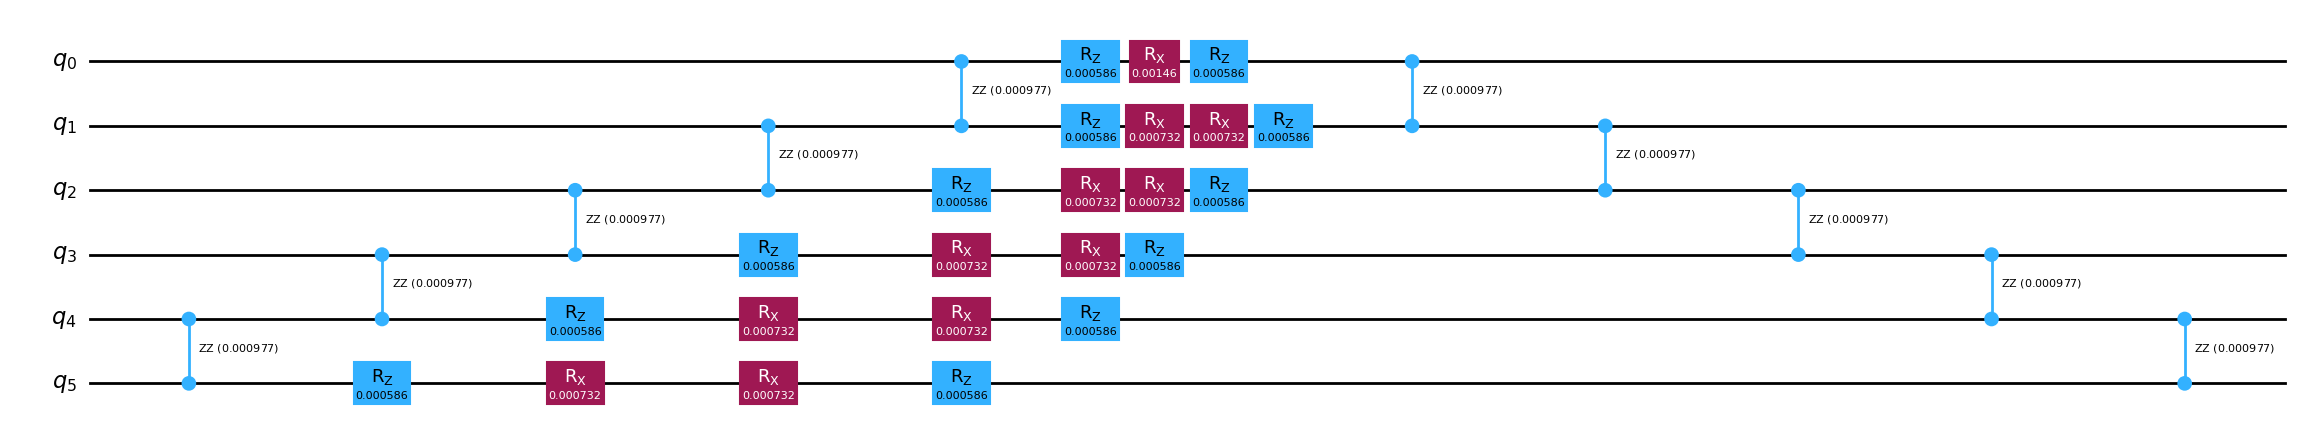

In [16]:
# Construct a single Trotter step of the target circuit
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

evolution_time = t
aqc_evolution_time = evolution_time
aqc_target_log2_num_trotter_steps = 8

aqc_target_step_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=1),
    time=aqc_evolution_time / 2**aqc_target_log2_num_trotter_steps,
)

print(
    f"This single Trotter step circuit will be repeated {2**aqc_target_log2_num_trotter_steps} times:"
)
aqc_target_step_circuit.draw("mpl", fold=-1)

In [17]:
# construct a good cirucit

ansatz_num_trotter_steps = 2

aqc_good_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=ansatz_num_trotter_steps),
    time=aqc_evolution_time,
)
# generate ansatz from a good circuit

from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit

# aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(
#     aqc_good_circuit, parameter_name="x"
# )
# aqc_ansatz.assign_parameters(aqc_initial_parameters).draw("mpl", fold=-1)
# depth_ansatz = aqc_ansatz.depth()
# print(depth_ansatz)

In [18]:
# set up quimb
from functools import partial
import quimb.tensor
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator

simulator_settings = QuimbSimulator(
    partial(quimb.tensor.Circuit, gate_contract="split-gate"),
    autodiff_backend="jax",
)

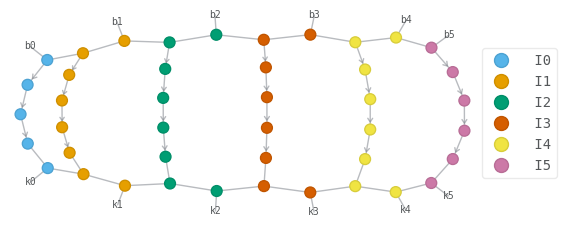

In [19]:
# construct target MPO - tensor network of single trotter step of target circuit
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit

aqc_target_mpo = tensornetwork_from_circuit(aqc_target_step_circuit, simulator_settings).get_uni()
aqc_target_mpo.draw(aqc_target_mpo.site_tags, show_tags=False)

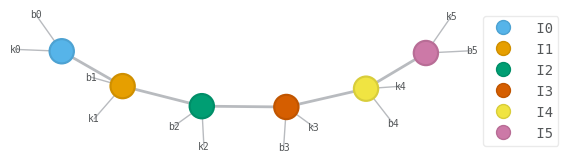

In [20]:
# contract and fuse multibonds to form MPO
for site in aqc_target_mpo.site_tags:
    aqc_target_mpo.contract(site, inplace=True)
aqc_target_mpo.fuse_multibonds_()

aqc_target_mpo.draw(aqc_target_mpo.site_tags, show_tags=False)

In [21]:
# cast to MPO object and compress

cutoff = 1e-8

aqc_target_mpo.view_as_(
    quimb.tensor.MatrixProductOperator,
    cyclic=False,
    L=coupling_map.num_nodes(),
)
aqc_target_mpo.compress(cutoff=cutoff)
aqc_target_mpo.show()

│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │


In [22]:
# repeatedly sqaure and compress MPO to represent an operator with many Trotter steps
for _ in range(aqc_target_log2_num_trotter_steps):
    aqc_target_mpo = aqc_target_mpo.apply(aqc_target_mpo)
    aqc_target_mpo.compress(cutoff=cutoff)
    aqc_target_mpo.show()
aqc_target_mpo

│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │


MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=4)

In [30]:
from ropt_aqc.comparison_methods import compress_HS_AQC_unitary

N_vals = range(1, 24)
df, aqc_ansatz, aqc_initial_parameters, aqc_final_parameters = compress_HS_AQC_unitary(gates_optimised, config, simulator_settings, aqc_target_mpo, N_vals)


=== Optimizing with N = 1 native layers ===
Evaluating loss function: 0.00092105556
Evaluating loss function: 0.0084269534
Evaluating loss function: 0.03325848
Evaluating loss function: 0.031010981
Evaluating loss function: 0.045277122
Intermediate result: Fidelity 0.045277122
Evaluating loss function: 0.0077320767
Evaluating loss function: 0.045812149
Intermediate result: Fidelity 0.045812149
Evaluating loss function: 0.071429826
Evaluating loss function: 0.16196852
Intermediate result: Fidelity 0.16196852
Evaluating loss function: 0.013755739
Evaluating loss function: 0.17995309
Intermediate result: Fidelity 0.17995309
Evaluating loss function: 0.25290947
Evaluating loss function: 0.032640793
Evaluating loss function: 0.27923037
Intermediate result: Fidelity 0.27923037
Evaluating loss function: 0.025060614
Evaluating loss function: 0.034714432
Evaluating loss function: 0.038305898
Evaluating loss function: 0.29468654
Intermediate result: Fidelity 0.29468654
Evaluating loss function:

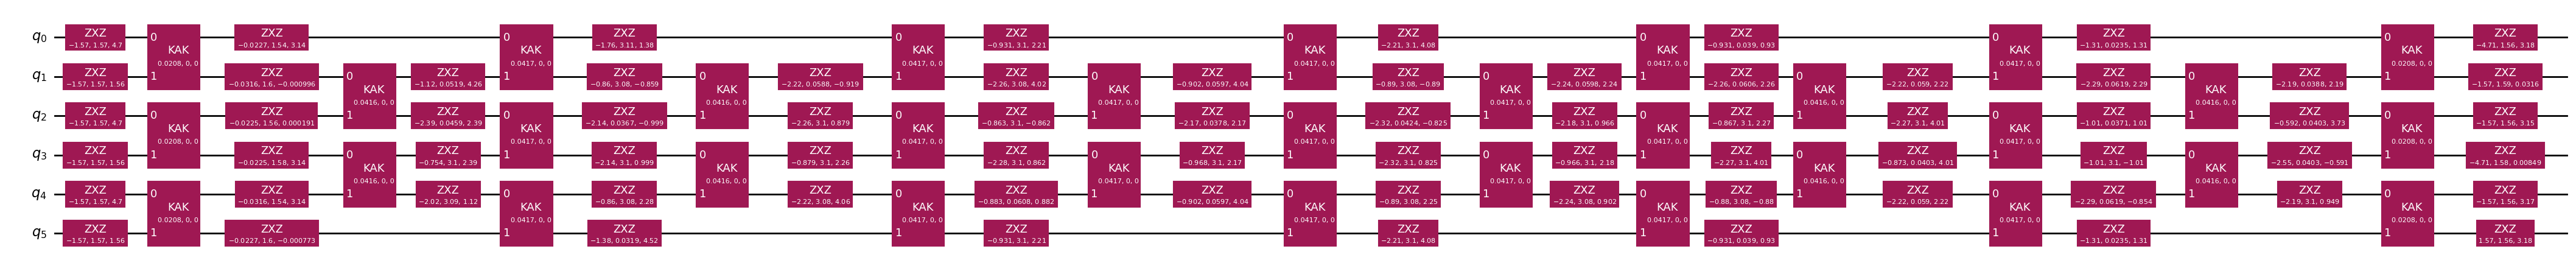

In [25]:
# generate ansatz from circuit
from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(
    qc_opt, parameter_name="x"
)
aqc_ansatz_original = aqc_ansatz.assign_parameters(aqc_initial_parameters)
aqc_ansatz_original.draw("mpl", fold=-1)
# aqc_ansatz_original.draw("mpl").savefig('Figures/initial_circuit_AQC-u_PXP_1step.pdf')

In [26]:
import jax.numpy as jnp

# Optimise with respect to fidelity
from scipy.optimize import OptimizeResult, minimize

from qiskit_addon_aqc_tensor.objective import MaximizeUnitaryFidelity

objective = MaximizeUnitaryFidelity(aqc_target_mpo, aqc_ansatz, simulator_settings)

stopping_point = 1e-5


def my_loss_function(*args):
    val, grad = objective.loss_function(*args)

    # Ensure val is a float (not quimb.Tensor or jax.Array)
    val = float(val) if hasattr(val, "item") else val
    grad = jnp.asarray(grad)

    print(f"Evaluating loss function: {1 - val:.8}")
    return val, grad



def callback(intermediate_result: OptimizeResult):
    print(f"Intermediate result: Fidelity {1 - intermediate_result.fun:.8}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration


result = minimize(
    my_loss_function,
    aqc_initial_parameters,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": 1000},
    callback=callback,
)
if result.status not in (
    0,
    1,
    99,
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(f"Optimization failed: {result.message} (status={result.status})")

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

Evaluating loss function: 0.97216735
Evaluating loss function: 0.29325515
Evaluating loss function: 0.99691847
Intermediate result: Fidelity 0.99691847
Evaluating loss function: 0.99974423
Intermediate result: Fidelity 0.99974423
Evaluating loss function: 0.99984269
Intermediate result: Fidelity 0.99984269
Evaluating loss function: 0.99996508
Intermediate result: Fidelity 0.99996508
Evaluating loss function: 0.99997706
Intermediate result: Fidelity 0.99997706
Evaluating loss function: 0.99999602
Intermediate result: Fidelity 0.99999602
Done after 6 iterations.


In [27]:
# from the optimised circuit 
aqc_optimised_block = aqc_ansatz.assign_parameters(aqc_final_parameters)

In [28]:
print("=== Complete Optimised Circuit ===")
aqc_optimised_block.draw("mpl")
depth_ansatz_opt = aqc_optimised_block.depth()
print(depth_ansatz_opt)

=== Complete Optimised Circuit ===
27


In [29]:
from qiskit.quantum_info import Operator
import numpy as np

if coupling_map.num_nodes() <= 8:
    # Build target operator (e.g., full evolution)
    target_operator = Operator(aqc_target_step_circuit)
    for _ in range(aqc_target_log2_num_trotter_steps):
        target_operator = target_operator @ target_operator

    # --- Initial Fidelity ---
    # decomposed_qc = decompose_unitary_gate(qc_opt)
    aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(qc_opt, parameter_name='x')
    initial_block = aqc_ansatz.assign_parameters(aqc_initial_parameters)
    initial_fidelity = abs(
        np.trace(Operator(initial_block).conjugate().to_matrix() @ target_operator.to_matrix())
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Initial Frobenius inner product: {initial_fidelity:.8}")

    # --- Final Fidelity ---
    final_fidelity = abs(
        np.trace(Operator(aqc_optimised_block).conjugate().to_matrix() @ target_operator.to_matrix())
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Final Frobenius inner product: {final_fidelity:.8}")


Initial Frobenius inner product: 0.97216864
Final Frobenius inner product: 0.99999608


In [31]:
import pandas as pd
file_path_ising = f'/Users/aag/Documents/ropt-aqc/method_comparison/results/hybrid_unitary_Ising_results_{t}.csv'

df.to_csv(file_path_ising, index=False, header=True)
# df.to_csv(file_path_ising, index=False, mode="a", header=False)

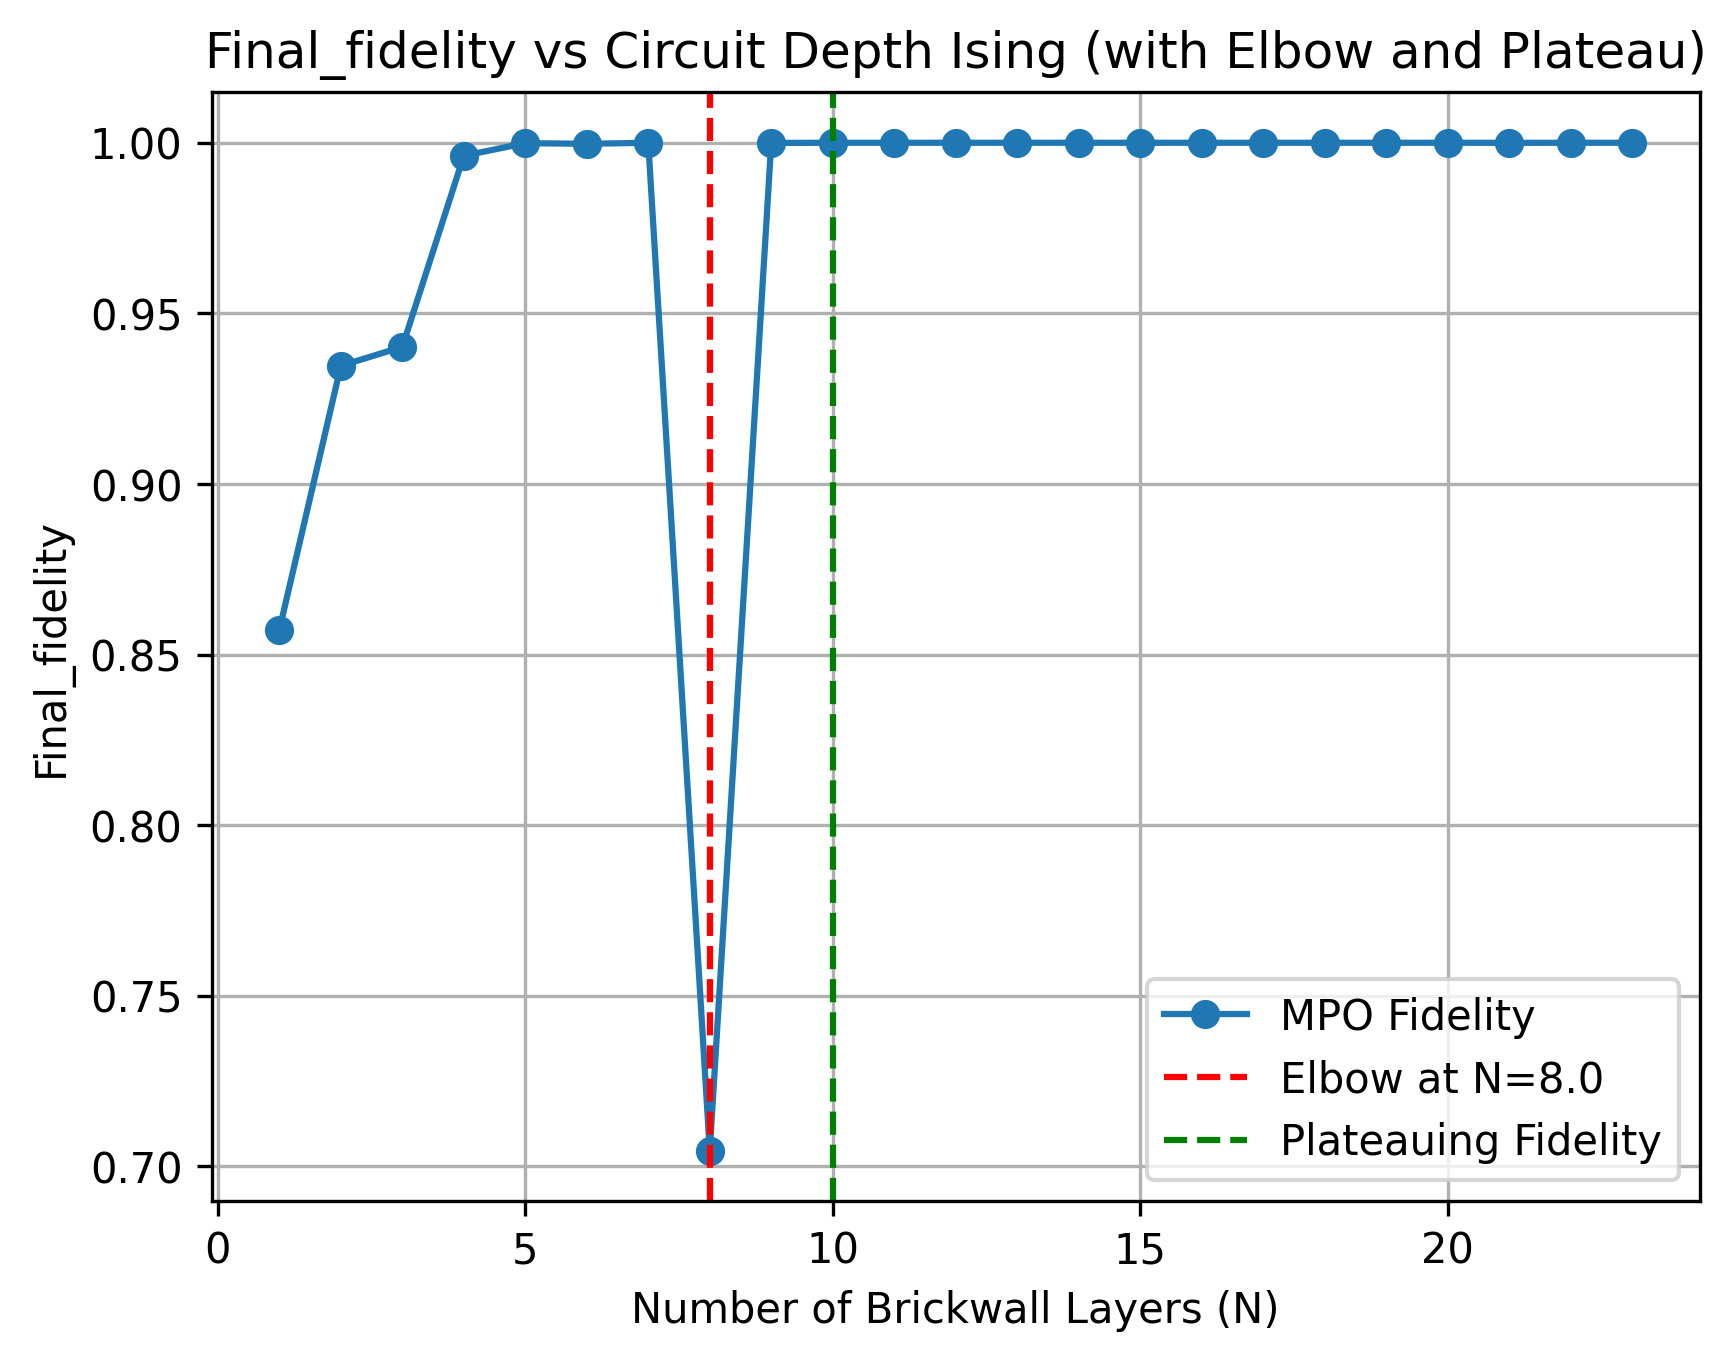


🔍 Suggested optimal compression depth: N = 10.0


In [33]:
from ropt_aqc.brickwall_opt import plot_fidelity

elbow_N, plateau_N = plot_fidelity(df, 'Final_fidelity', t, 1e-3, method, system, save_path=True)

In [ ]:
# Compress circuit
N_vals = [int(plateau_N)]
df_compressed, aqc_ansatz_compressed, aqc_initial_parameters_compressed, aqc_final_parameters_compressed = compress_HS_AQC_unitary(gates_optimised, config, simulator_settings, aqc_target_mpo, N_vals)


=== Optimizing with N = 16 native layers ===
Evaluating loss function: 0.025441298
Evaluating loss function: 0.11424364
Intermediate result: Fidelity 0.11424364
Evaluating loss function: 0.16020885
Intermediate result: Fidelity 0.16020885
Evaluating loss function: 0.2197673
Intermediate result: Fidelity 0.2197673
Evaluating loss function: 0.29648019
Intermediate result: Fidelity 0.29648019
Evaluating loss function: 0.11683435
Evaluating loss function: 0.36624085
Intermediate result: Fidelity 0.36624085
Evaluating loss function: 0.40617534
Intermediate result: Fidelity 0.40617534
Evaluating loss function: 0.43322866
Intermediate result: Fidelity 0.43322866
Evaluating loss function: 0.48993234
Intermediate result: Fidelity 0.48993234
Evaluating loss function: 0.52725629
Intermediate result: Fidelity 0.52725629
Evaluating loss function: 0.58174093
Intermediate result: Fidelity 0.58174093
Evaluating loss function: 0.60587093
Evaluating loss function: 0.62906189
Intermediate result: Fideli

In [61]:
print("=== Compressed Optimised Circuit ===")
print(aqc_ansatz_compressed.depth())
param_binding = {param: value for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed)}
aqc_optimised_compressed = aqc_ansatz_compressed.assign_parameters(param_binding)

aqc_optimised_compressed.draw("mpl")
aqc_optimised_compressed.draw("mpl").savefig('optimised_circuit_hybrid-AQC-u_Ising.pdf')
# print(aqc_optimised_compressed.depth())

=== Compressed Optimised Circuit ===
16


In [62]:
print("\n=== Compressed Optimised Parameters ===")
for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed):
    print(f"{param}: {value:.6f}")


=== Compressed Optimised Parameters ===
theta[0]: -0.081914
theta[1]: 1.834488
theta[2]: 4.455298
theta[3]: -4.336043
theta[4]: 1.521943
theta[5]: 1.782536
theta[6]: -1.234101
theta[7]: 1.627671
theta[8]: 4.475792
theta[9]: -4.790211
theta[10]: 1.612892
theta[11]: 1.795639
theta[12]: -4.440766
theta[13]: 1.528884
theta[14]: 1.894353
theta[15]: 2.116043
theta[16]: 1.396634
theta[17]: -1.413238
theta[18]: 0.343454
theta[19]: -0.017677
theta[20]: -0.000226
theta[21]: 0.170138
theta[22]: 1.693265
theta[23]: 2.665387
theta[24]: 0.257290
theta[25]: 2.531458
theta[26]: -0.084454
theta[27]: 0.340278
theta[28]: -0.000506
theta[29]: 0.001397
theta[30]: -0.279952
theta[31]: -0.303822
theta[32]: -0.011249
theta[33]: -0.747334
theta[34]: 0.136555
theta[35]: 1.033002
theta[36]: 0.495981
theta[37]: -0.007834
theta[38]: -0.004010
theta[39]: -6.183791
theta[40]: 0.374564
theta[41]: 3.300223
theta[42]: -2.658414
theta[43]: 0.108600
theta[44]: 3.690723
theta[45]: 0.613497
theta[46]: 0.034739
theta[47]: 

In [63]:
print(f"Number of parameters in ansatz: {len(aqc_ansatz_compressed.parameters)}")
print(f"Physical depth of compressed circuit: {aqc_optimised_compressed.depth()}")
print(f"Compression ratio: {35 / aqc_optimised_compressed.depth() }")


Number of parameters in ansatz: 186
Physical depth of compressed circuit: 16
Compression ratio: 2.1875


# Heisenberg

In [141]:
# Heisenberg
t = 0.25
h = 0.75
n_repetitions = 5
system = 'heisenberg'

terms_h, params_h = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=[1.0, 1.0, -0.5], h=[0.75, 0.0, 0.0])

J= params_h['J']
h= params_h['h']

In [142]:
from ropt_aqc.spin_systems import get_brickwall_trotter_gates_spin_chain

gates_heisenberg = get_brickwall_trotter_gates_spin_chain(t=t, n_sites=num_sites, n_repetitions=n_repetitions, hamiltonian=system, degree=degree, J=J, h=h)

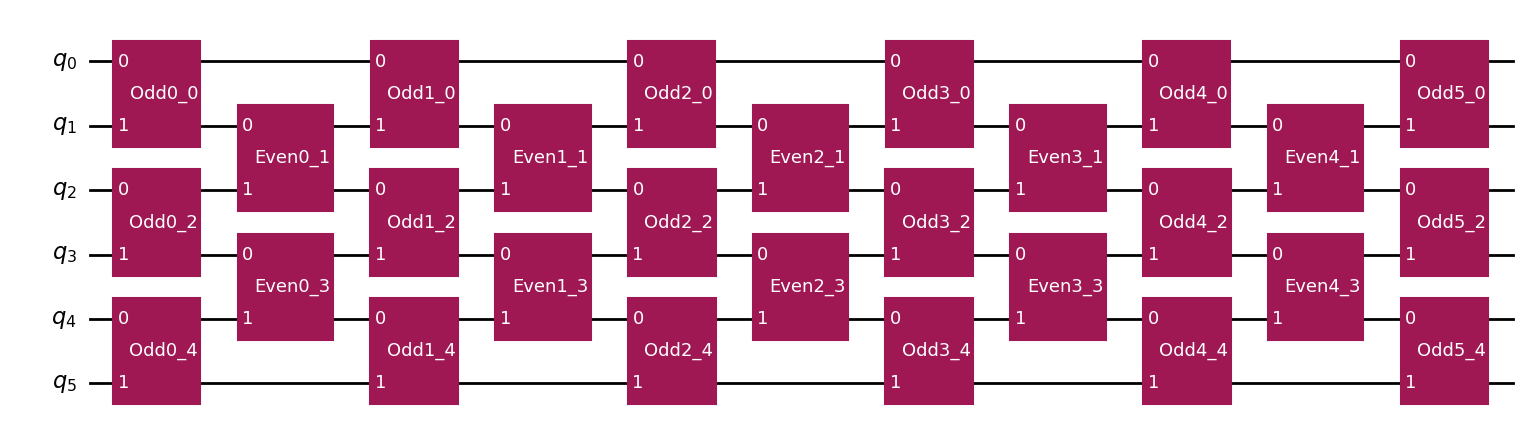

In [ ]:
from ropt_aqc.circuit_building import transform_to_bw_qc_unitarygate

qc_initial_h = transform_to_bw_qc_unitarygate(num_sites=num_sites, system = system, gates=gates_heisenberg)
depth_h = qc_initial_h.depth()
qc_initial_h.draw('mpl')

In [144]:
# TN for optimisation
from ropt_aqc.brickwall_circuit import get_initial_gates
gates_h = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=True, J=J, h=h)
print(np.array(gates_h).shape)  # Should be (N, 4, 4) for 2-qubit gates

(28, 2, 2, 2, 2)


In [145]:
from ropt_aqc.save_model import load_reference
import os
import yaml
repo_root = "/Users/aag/Documents/ropt-aqc/"
config_file = os.path.join(repo_root, "run", system, "configs", "config.yml") 

with open(config_file, "r") as f:
    config = yaml.safe_load(f)

config['reference_dir'] = f'/Users/aag/Documents/ropt-aqc/run/{system}/reference'

U_ref, t, _, _, _, _, _, _, _, J, h= load_reference(config['reference_dir'], config['n_sites'], config['n_repetitions'], config['t'])

In [146]:
from ropt_aqc.tn_helpers import left_to_right_QR_sweep

U_ref = left_to_right_QR_sweep(U_ref, get_norm=False, normalize=config['normalize_reference'])
print("U_ref shape:", [m.shape for m in U_ref])

U_ref shape: [(1, 2, 2, 4), (4, 2, 2, 16), (16, 2, 2, 33), (33, 2, 2, 16), (16, 2, 2, 4), (4, 2, 2, 1)]


Start Riemannian ADAM optimization ...
	 0 	Current cost:  3.1528563186888903e-06
	 1 	Current cost:  0.0008704070581657675
	 2 	Current cost:  0.00010205318896394644
	 3 	Current cost:  0.00020570333941272168
	 4 	Current cost:  0.0003747591539728923
	 5 	Current cost:  0.0003463962374810059
	 6 	Current cost:  0.00019490333482496958
	 7 	Current cost:  4.7192160652187454e-05
	 8 	Current cost:  4.02600354267868e-05
	 9 	Current cost:  0.0001544120969343421
	 10 	Current cost:  0.00021672882708201335
	 11 	Current cost:  0.0001511149113468946
	 12 	Current cost:  5.0233636375907054e-05
	 13 	Current cost:  1.6454252889319676e-05
	 14 	Current cost:  5.0094471147899e-05
	 15 	Current cost:  8.743822133450152e-05
	 16 	Current cost:  9.318634349497756e-05
	 17 	Current cost:  7.339485043234006e-05
	 18 	Current cost:  4.255021176136076e-05
	 19 	Current cost:  1.761348321149825e-05
	 20 	Current cost:  1.7393349002414737e-05
	 21 	Current cost:  4.016918793725566e-05
	 22 	Current cost:

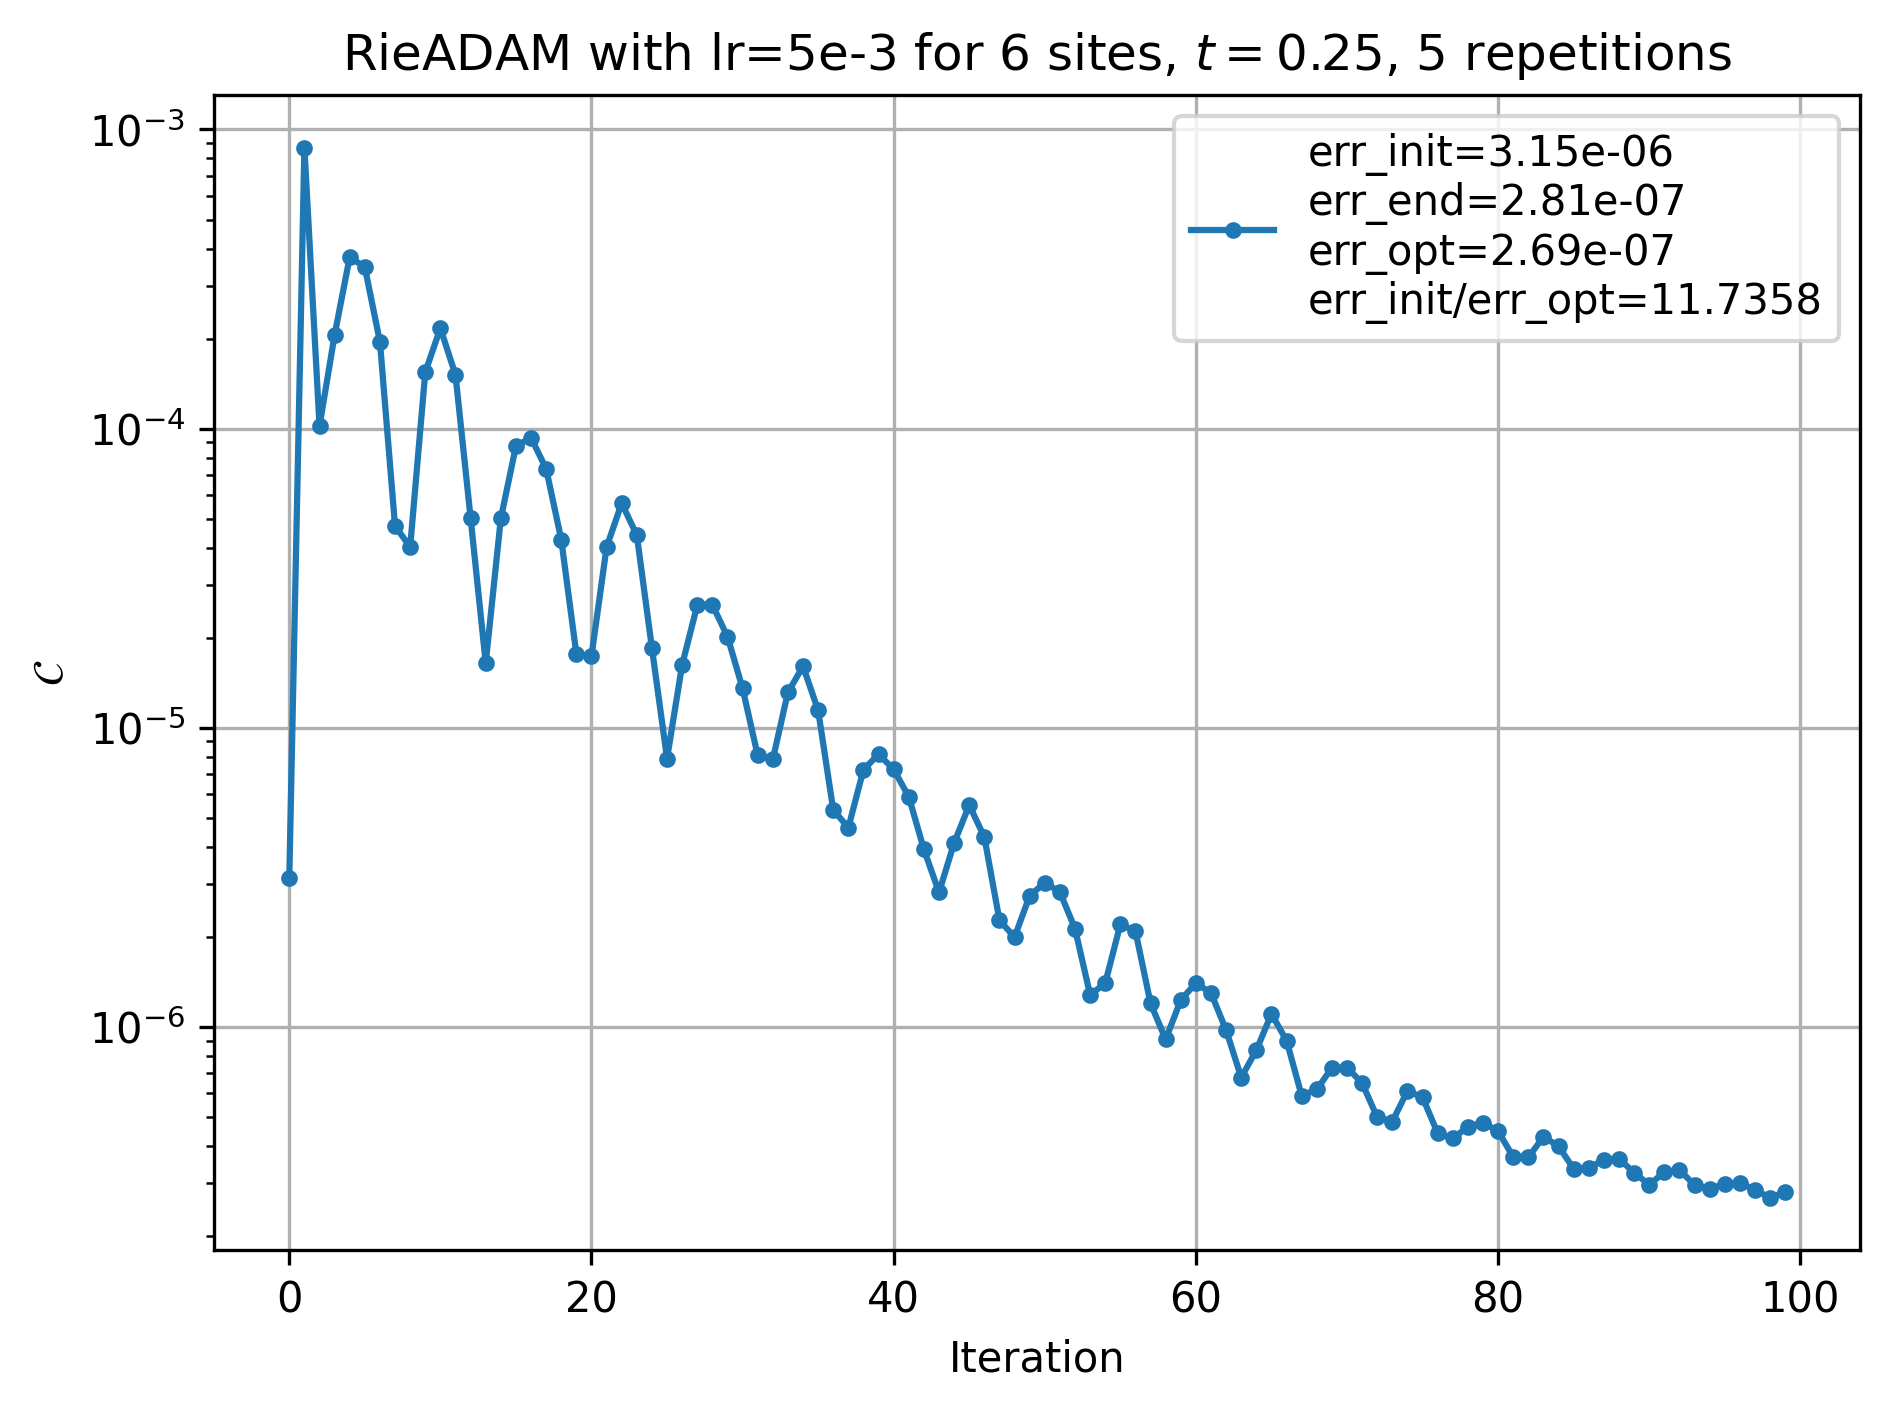

In [147]:
from ropt_aqc.brickwall_opt import optimize_swap_network_circuit_RieADAM

gates_optimised_h, err_iter = optimize_swap_network_circuit_RieADAM(config, U_ref, gates_h)

In [148]:
# from qiskit import QuantumCircuit
# from qiskit.quantum_info import Statevector
# from ropt_aqc.comparison_methods import compress_HS

# N_vals = range(1,depth_h)

# df_h, gates_optimised_reshaped_h = compress_HS(gates_h, config, U_ref, N_vals, qc_initial_h)

In [149]:
# from ropt_aqc.brickwall_opt import plot_fidelity

# elbow_N_h, plateau_N_h = plot_fidelity(df_h, 'statevector_fidelity', n_repetitions, 1e-3, method, system)

In [150]:
# # Compress circuit
# N_vals = [int(plateau_N_h)]
# df_compressed, gates_optimised_reshaped_compressed_h = compress_HS(gates_h, config, U_ref, N_vals, qc_initial_h)

11


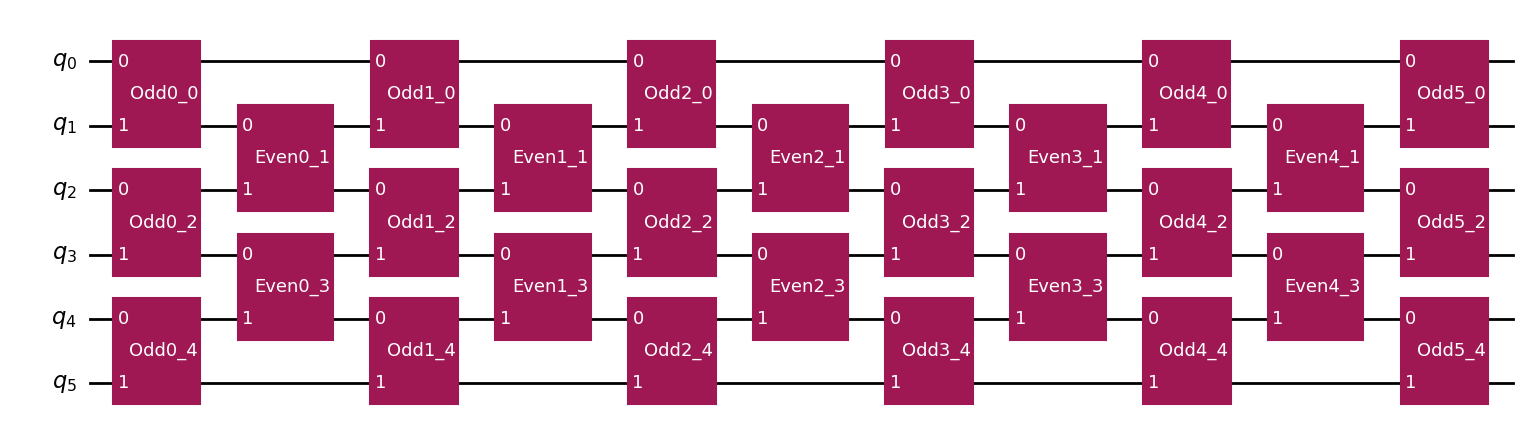

In [ ]:
gates_optimised_h = gates_optimised_h.reshape((len(gates_optimised_h), 4, 4))
# gates_optimised_h = gates_optimised_reshaped_compressed_h
qc_opt_h = transform_to_bw_qc_unitarygate(num_sites=num_sites, system = system, gates=gates_optimised_h)
depth_opt_h = qc_opt_h.depth()
print(depth_opt_h)
qc_opt_h.draw('mpl')

In [152]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_pauli_op
from qiskit.quantum_info import SparsePauliOp
from rustworkx.generators import path_graph

hamiltonian_h = hamiltonian_to_sparse_pauli_op(terms_h, num_qubits=num_sites)
print('Hamiltonian: ', hamiltonian_h)

observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (num_sites // 2 - 1, num_sites // 2), 1.0)], num_qubits=num_sites
)
print("Observable:", observable)

coupling_map = path_graph(num_sites)

Hamiltonian:  SparsePauliOp(['XXIIII', 'YYIIII', 'ZZIIII', 'IXXIII', 'IYYIII', 'IZZIII', 'IIXXII', 'IIYYII', 'IIZZII', 'IIIXXI', 'IIIYYI', 'IIIZZI', 'IIIIXX', 'IIIIYY', 'IIIIZZ', 'XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX'],
              coeffs=[ 1.  +0.j,  1.  +0.j, -0.5 +0.j,  1.  +0.j,  1.  +0.j, -0.5 +0.j,
  1.  +0.j,  1.  +0.j, -0.5 +0.j,  1.  +0.j,  1.  +0.j, -0.5 +0.j,
  1.  +0.j,  1.  +0.j, -0.5 +0.j,  0.75+0.j,  0.75+0.j,  0.75+0.j,
  0.75+0.j,  0.75+0.j,  0.75+0.j])
Observable: SparsePauliOp(['IIZZII'],
              coeffs=[1.+0.j])


In [153]:
# baseline depth
from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit

ansatz_num_trotter_steps = 5

aqc_good_circuit_h = generate_time_evolution_circuit(
    hamiltonian_h,
    synthesis=SuzukiTrotter(reps=ansatz_num_trotter_steps),
    time=aqc_evolution_time,
)

aqc_ansatz_h, aqc_initial_parameters_h = generate_ansatz_from_circuit(
    aqc_good_circuit_h, parameter_name="x"
)
aqc_ansatz_h.assign_parameters(aqc_initial_parameters_h).draw("mpl", fold=-1)
original_depth_h = aqc_ansatz_h.depth()

This single Trotter step circuit will be repeated 1024 times:


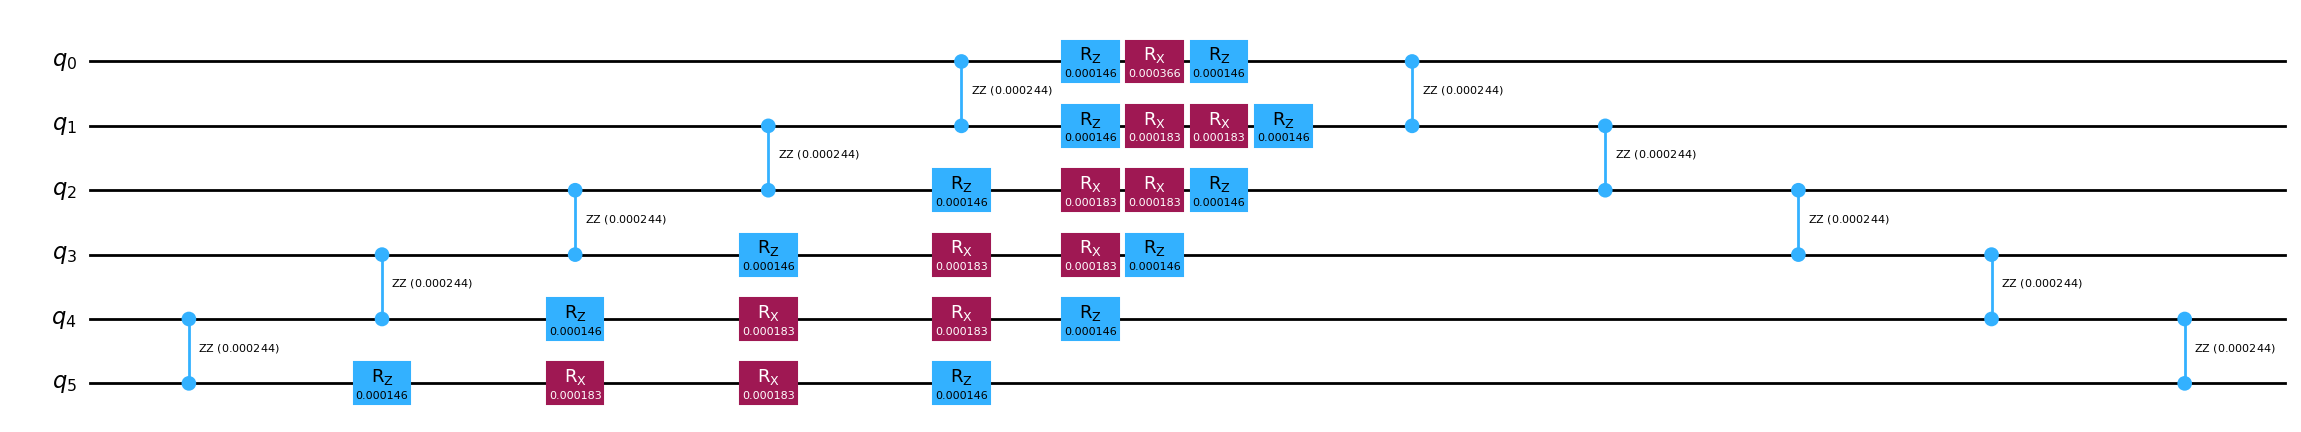

In [154]:
# Construct a single Trotter step of the target circuit
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

aqc_evolution_time = t
aqc_target_log2_num_trotter_steps = 10

aqc_target_step_circuit_h = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=1),
    time=aqc_evolution_time / 2**aqc_target_log2_num_trotter_steps,
)

print(
    f"This single Trotter step circuit will be repeated {2**aqc_target_log2_num_trotter_steps} times:"
)
aqc_target_step_circuit_h.draw("mpl", fold=-1)

In [155]:
# set up quimb
from functools import partial
import quimb.tensor
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator

simulator_settings = QuimbSimulator(
    partial(quimb.tensor.Circuit, gate_contract="split-gate"),
    autodiff_backend="jax",
)

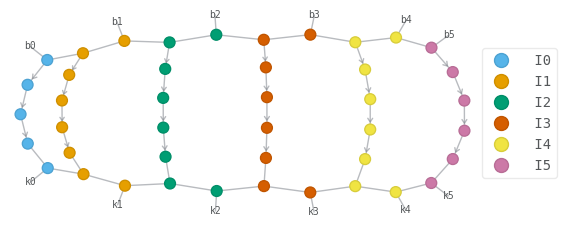

In [156]:
# construct target MPO - tensor network of single trotter step of target circuit
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit

aqc_target_mpo_h= tensornetwork_from_circuit(aqc_target_step_circuit_h, simulator_settings).get_uni()
aqc_target_mpo_h.draw(aqc_target_mpo_h.site_tags, show_tags=False)

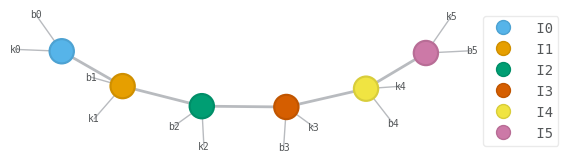

In [157]:
# contract and fuse multibonds to form MPO
for site in aqc_target_mpo_h.site_tags:
    aqc_target_mpo_h.contract(site, inplace=True)
aqc_target_mpo_h.fuse_multibonds_()

aqc_target_mpo_h.draw(aqc_target_mpo_h.site_tags, show_tags=False)

In [158]:
# cast to MPO object and compress

cutoff = 1e-8

aqc_target_mpo_h.view_as_(
    quimb.tensor.MatrixProductOperator,
    cyclic=False,
    L=coupling_map.num_nodes(),
)
aqc_target_mpo_h.compress(cutoff=cutoff)
aqc_target_mpo_h.show()

│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │


In [159]:
# repeatedly sqaure and compress MPO to represent an operator with many Trotter steps
for _ in range(aqc_target_log2_num_trotter_steps):
    aqc_target_mpo_h = aqc_target_mpo_h.apply(aqc_target_mpo_h)
    aqc_target_mpo_h.compress(cutoff=cutoff)
    aqc_target_mpo_h.show()
aqc_target_mpo_h

│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │


MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=4)

In [160]:
from ropt_aqc.comparison_methods import compress_HS_AQC_unitary

N_vals = range(1, 24)
df_h, aqc_ansatz_h, aqc_initial_parameters_h, aqc_final_parameters_h = compress_HS_AQC_unitary(gates_optimised_h, config, simulator_settings, aqc_target_mpo_h, N_vals, n_repetitions, terms_h)


=== Optimizing with N = 1 native layers ===
Evaluating loss function: 7.0598044e-05
Evaluating loss function: 0.008961659
Evaluating loss function: 0.012975353
Intermediate result: Fidelity 0.012975353
Evaluating loss function: 0.070670938
Evaluating loss function: 0.028674951
Evaluating loss function: 0.16081049
Evaluating loss function: 0.16761222
Intermediate result: Fidelity 0.16761222
Evaluating loss function: 0.026710447
Evaluating loss function: 0.005401888
Evaluating loss function: 0.013298102
Evaluating loss function: 0.17414053
Intermediate result: Fidelity 0.17414053
Evaluating loss function: 0.26161023
Evaluating loss function: 0.086964485
Evaluating loss function: 0.32816882
Intermediate result: Fidelity 0.32816882
Evaluating loss function: 0.076008085
Evaluating loss function: 0.40269222
Intermediate result: Fidelity 0.40269222
Evaluating loss function: 0.65450642
Intermediate result: Fidelity 0.65450642
Evaluating loss function: 0.51126412
Evaluating loss function: 0.74

=== Complete Optimised Circuit ===


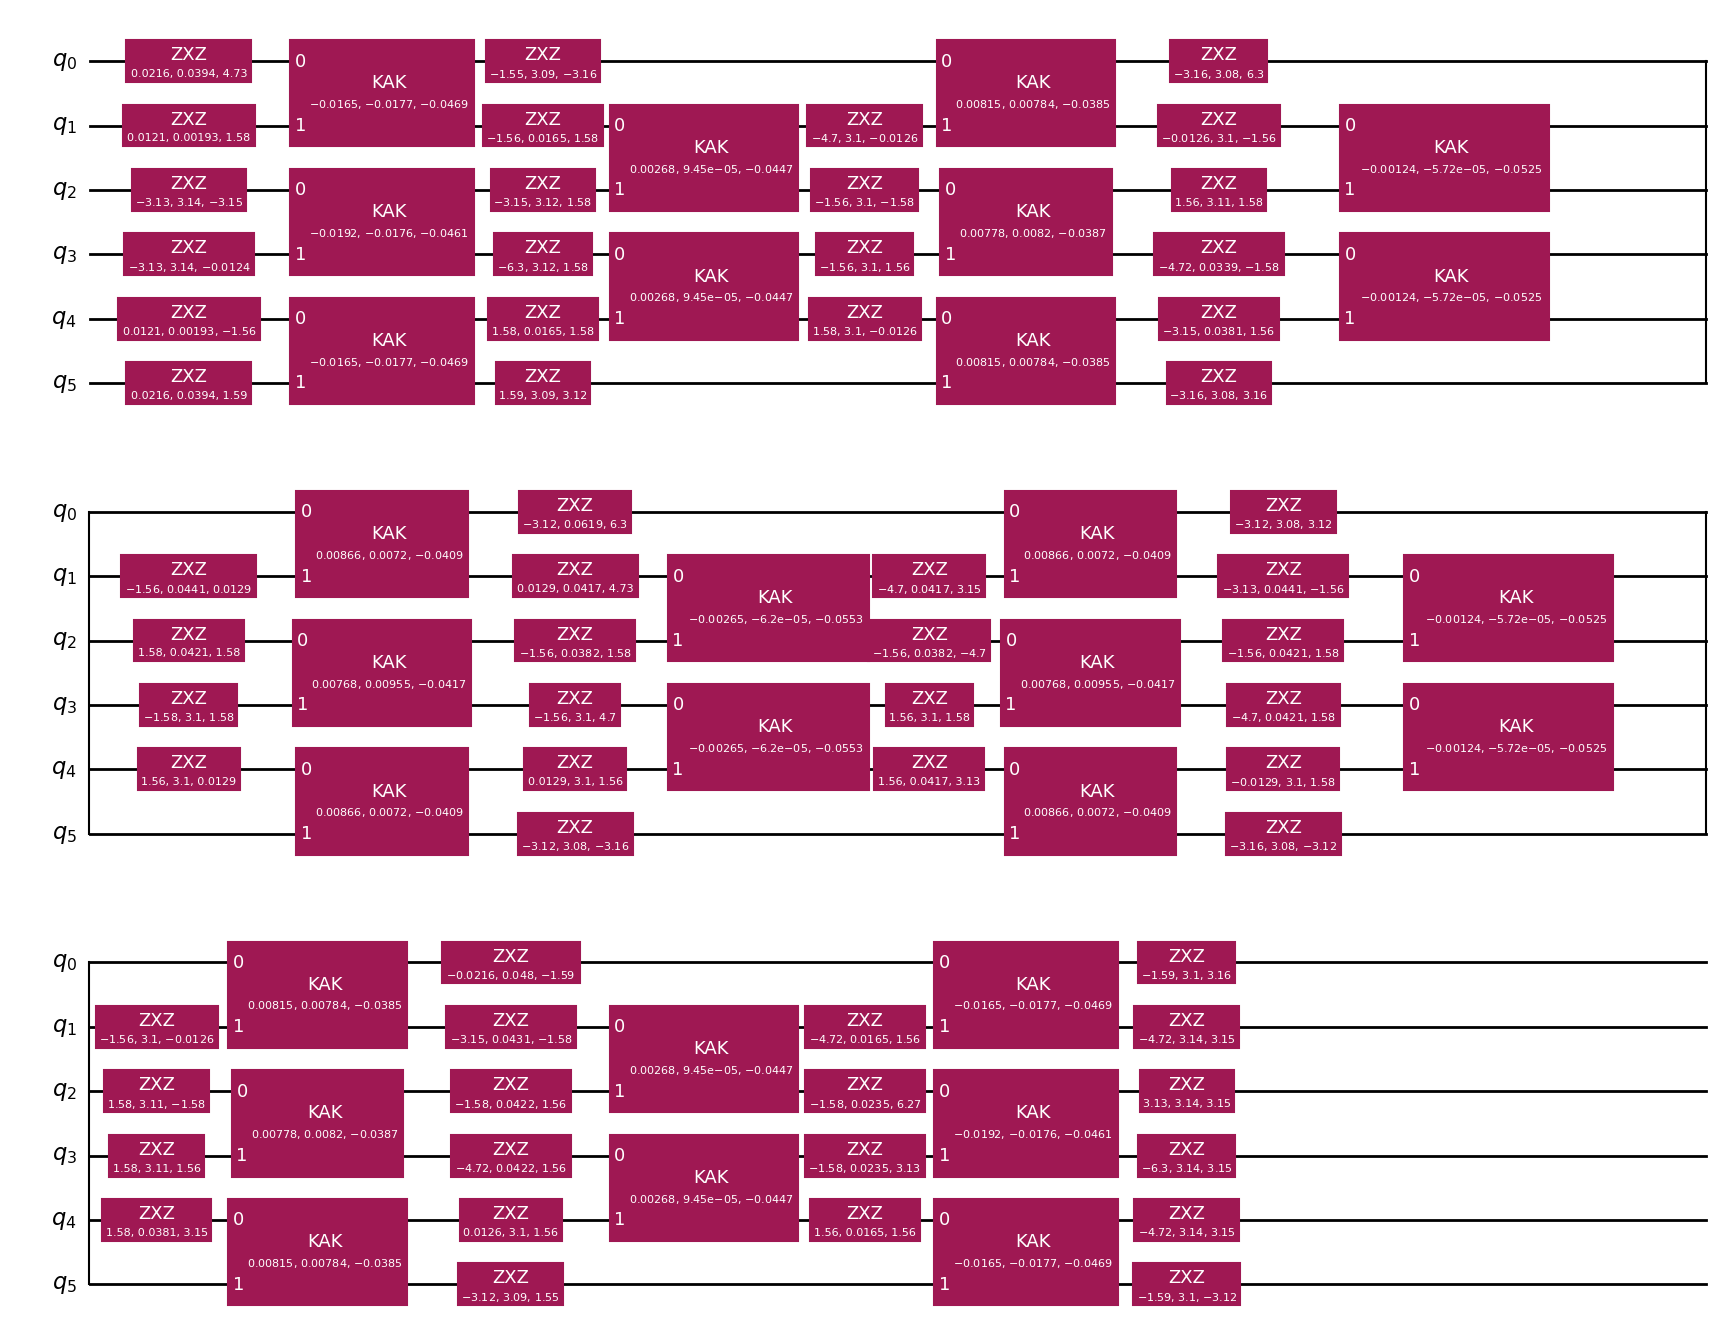

In [161]:
# from the optimised circuit 
aqc_optimised_block_h = aqc_ansatz_h.assign_parameters(aqc_final_parameters_h)
print("=== Complete Optimised Circuit ===")
aqc_optimised_block_h.draw("mpl")

In [162]:
from qiskit.quantum_info import Operator
import numpy as np

if coupling_map.num_nodes() <= 8:
    # Build target operator (e.g., full evolution)
    target_operator = Operator(aqc_target_step_circuit_h).power(2 ** aqc_target_log2_num_trotter_steps)

    # --- Initial Fidelity ---
    initial_block = aqc_ansatz_h.assign_parameters(aqc_initial_parameters_h)
    initial_fidelity_h = abs(
        np.trace(Operator(initial_block).conjugate().to_matrix() @ target_operator.to_matrix())
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Initial Frobenius inner product: {initial_fidelity_h:.8}")

    # --- Final Fidelity ---
    final_fidelity_h = abs(
        np.trace(Operator(aqc_optimised_block_h).conjugate().to_matrix() @ target_operator.to_matrix())
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Final Frobenius inner product: {final_fidelity_h:.8}")

Initial Frobenius inner product: 0.47538976
Final Frobenius inner product: 0.99992873


In [107]:
import pandas as pd
file_path_heisenberg = f'/Users/aag/Documents/ropt-aqc/method_comparison/results/hybrid_unitary_Heisenberg_results_{t}_0.4.csv'

df_h.to_csv(file_path_heisenberg, index=False, header=True)
# df_h.to_csv(file_path_heisenberg, index=False, mode="a", header=False)

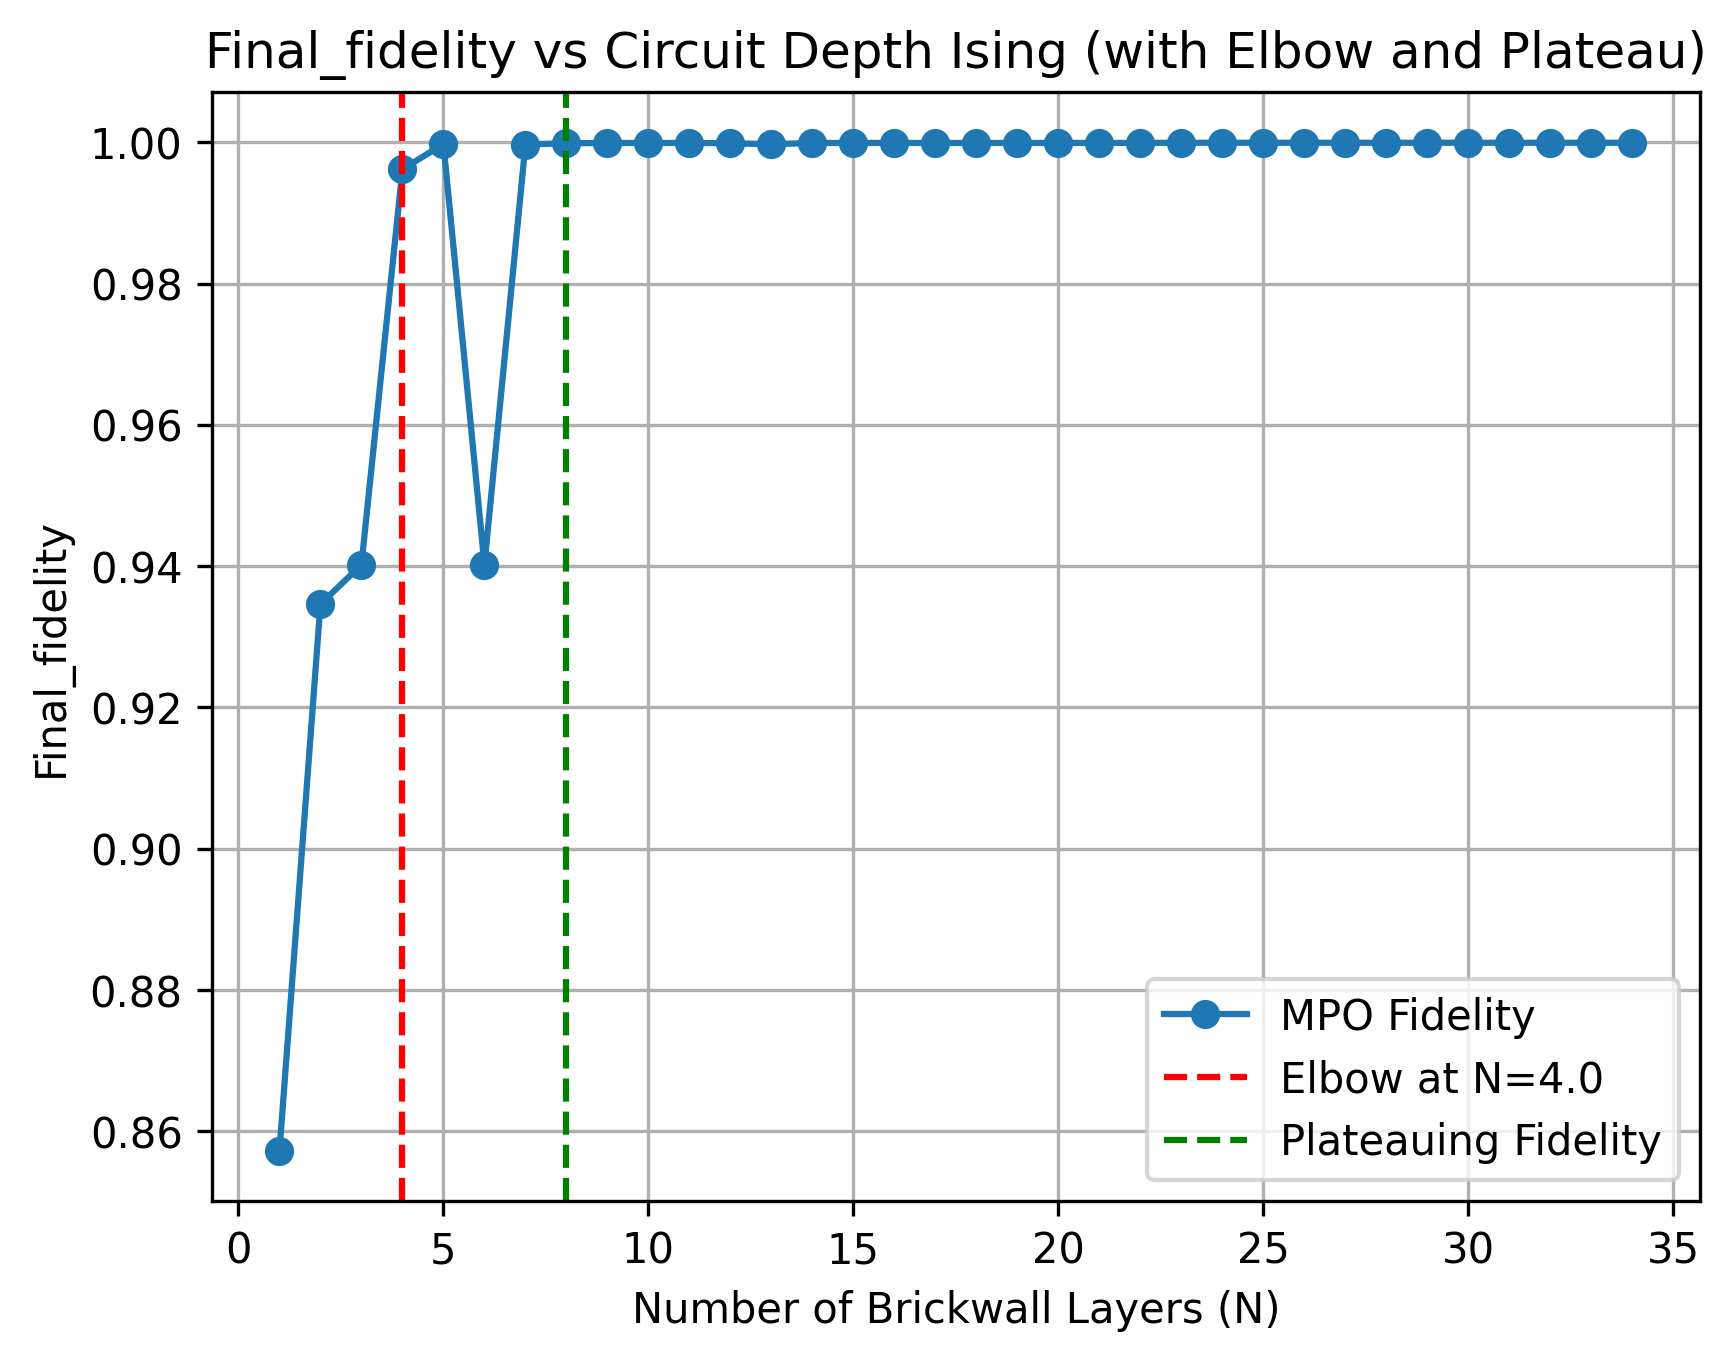


🔍 Suggested optimal compression depth: N = 8.0


In [108]:
from ropt_aqc.brickwall_opt import plot_fidelity

elbow_N_h, plateau_N_h = plot_fidelity(df_h, 'Final_fidelity', t, 1e-2, method, system)

In [110]:
# Compress circuit
N_vals = [int(plateau_N_h)]
df_compressed_h, aqc_ansatz_compressed_h, aqc_initial_parameters_compressed_h, aqc_final_parameters_compressed_h = compress_HS_AQC_unitary(gates_optimised_h, config, simulator_settings, aqc_target_mpo_h, N_vals, n_repetitions, terms_h)


=== Optimizing with N = 8 native layers ===
Evaluating loss function: 0.0045222096
Evaluating loss function: 0.12541748
Evaluating loss function: 0.12503259
Intermediate result: Fidelity 0.12503259
Evaluating loss function: 0.10653684
Evaluating loss function: 0.14165303
Intermediate result: Fidelity 0.14165303
Evaluating loss function: 0.044352661
Evaluating loss function: 0.22781544
Evaluating loss function: 0.38415355
Intermediate result: Fidelity 0.38415355
Evaluating loss function: 0.43593791
Evaluating loss function: 0.48623646
Intermediate result: Fidelity 0.48623646
Evaluating loss function: 0.27233229
Evaluating loss function: 0.60390075
Intermediate result: Fidelity 0.60390075
Evaluating loss function: 0.77666049
Intermediate result: Fidelity 0.77666049
Evaluating loss function: 0.86442342
Intermediate result: Fidelity 0.86442342
Evaluating loss function: 0.9276262
Intermediate result: Fidelity 0.9276262
Evaluating loss function: 0.95279974
Intermediate result: Fidelity 0.95

In [111]:
print("=== Compressed Optimised Circuit ===")
aqc_optimised_compressed_h = aqc_ansatz_compressed_h.assign_parameters(aqc_final_parameters_compressed_h)
aqc_optimised_compressed_h.draw("mpl")
aqc_optimised_compressed_h.draw("mpl").savefig('optimised_circuit_hybrid-AQC-u_Heisenberg.pdf')

=== Compressed Optimised Circuit ===


In [54]:
print("\n=== Compressed Optimised Parameters ===")
import pandas as pd
for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed):
    print(f"{param}: {value:.6f}")

df_params = pd.DataFrame({'parameters': aqc_final_parameters_compressed})
df_params.to_csv('aqc_hybrid_unitary_parameters_Ising.csv', index=False)


=== Compressed Optimised Parameters ===
theta[0]: -0.769005
theta[1]: 1.787778
theta[2]: 1.272258
theta[3]: -2.235299
theta[4]: 1.410224
theta[5]: 4.517903
theta[6]: -2.024971
theta[7]: 1.408061
theta[8]: 4.480850
theta[9]: -2.024971
theta[10]: 1.408061
theta[11]: 1.339257
theta[12]: -2.235299
theta[13]: 1.410224
theta[14]: 4.517903
theta[15]: -0.769005
theta[16]: 1.787778
theta[17]: 1.272258
theta[18]: 0.437270
theta[19]: 0.004357
theta[20]: -0.005474
theta[21]: -0.711879
theta[22]: 2.416451
theta[23]: 3.305560
theta[24]: -0.082840
theta[25]: 1.660355
theta[26]: 2.555521
theta[27]: -1.148651
theta[28]: -0.001548
theta[29]: -0.000077
theta[30]: 0.055867
theta[31]: 2.078227
theta[32]: 0.930307
theta[33]: 0.055867
theta[34]: 1.063366
theta[35]: 2.211286
theta[36]: 0.437270
theta[37]: 0.004357
theta[38]: -0.005474
theta[39]: -0.082840
theta[40]: 1.660355
theta[41]: 2.555521
theta[42]: -0.711879
theta[43]: 2.416451
theta[44]: 0.163967
theta[45]: 0.256155
theta[46]: 0.686506
theta[47]: 0.0

In [112]:
print(f"Number of parameters in ansatz: {len(aqc_ansatz_compressed_h.parameters)}")
print(f"Physical depth of compressed circuit: {aqc_optimised_compressed_h.depth()}")
print(f"Compression ratio: {83 / aqc_optimised_compressed_h.depth()}")


Number of parameters in ansatz: 96
Physical depth of compressed circuit: 8
Compression ratio: 10.375
